In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [2]:
def thinning(image):
    skeleton = image.copy()
    skeleton_prev = np.zeros_like(image)
    while True:
        # Apply Zhang-Suen thinning algorithm
        skeleton_prev = skeleton.copy()
        skeleton = zhang_suen_thinning(skeleton)
        if np.array_equal(skeleton_prev, skeleton):
            break
    return skeleton

def zhang_suen_thinning(image):
    image = image // 255  # Normalize to 0 and 1
    skeleton = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            p2, p3, p4, p5, p6, p7, p8, p9 = get_neighborhood(image, i, j)
            A = (p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9) / 255
            B = sum(abs(p - q) for p, q in zip([p2, p3, p4, p5, p6, p7, p8, p9], [p2, p3, p4, p5, p6, p7, p8, p9])) / 255
            m1 = (p2 * p4 * p6) if 2 <= A <= 6 and B == 1 else 0
            m2 = (p4 * p6 * p8) if 2 <= A <= 6 and B == 1 else 0
            if m1 == 0 and m2 == 0:
                skeleton[i, j] = image[i, j]
    return skeleton * 255

def get_neighborhood(image, i, j):
    p2 = image[i - 1, j]
    p3 = image[i - 1, j + 1]
    p4 = image[i, j + 1]
    p5 = image[i + 1, j + 1]
    p6 = image[i + 1, j]
    p7 = image[i + 1, j - 1]
    p8 = image[i, j - 1]
    p9 = image[i - 1, j - 1]
    return p2, p3, p4, p5, p6, p7, p8, p9


In [67]:
def erode(binary, kernel_size=(3, 3)):
    kh, kw = kernel_size
    padded_binary = np.pad(binary, ((kh//2, kh//2), (kw//2, kw//2)), mode='constant', constant_values=0)
    eroded = np.zeros_like(binary)
    height, width = binary.shape
    for i in range(height):
        for j in range(width):
            region = padded_binary[i:i + kh, j:j + kw]
            if np.all(region == 255):
                eroded[i, j] = 255
    return eroded

def dilate(binary, kernel_size=(3, 3)):
    kh, kw = kernel_size
    padded_binary = np.pad(binary, ((kh//2, kh//2), (kw//2, kw//2)), mode='constant', constant_values=0)
    dilated = np.zeros_like(binary)
    height, width = binary.shape
    for i in range(height):
        for j in range(width):
            region = padded_binary[i:i + kh, j:j + kw]
            if np.any(region == 255):
                dilated[i, j] = 255
    return dilated

In [68]:
def skeletonize(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    skeleton = np.zeros_like(binary)
    temp = np.zeros_like(binary)

    while True:
      # Step 1: Erosion
      eroded = erode(binary)

      # Step 2: Dilation
      dilated = dilate(eroded)

      # Step 3: Difference
      temp = cv2.subtract(binary, dilated)
      skeleton = cv2.bitwise_or(skeleton, temp)
      binary = eroded.copy()

      # Exit loop if no further changes
      if cv2.countNonZero(binary) == 0:
          break

    # Step 5: Post-processing
    skeleton = thinning(skeleton)

    return skeleton

In [55]:
# Load images
images = [cv2.imread('/content/q8_5.jpg'), cv2.imread('/content/q8_6.png'), cv2.imread('/content/q8_7.png')]

Skeleton 1


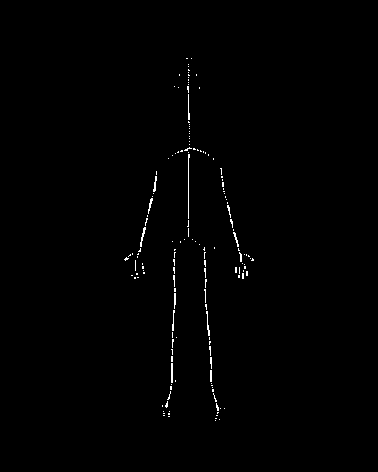

Skeleton 2


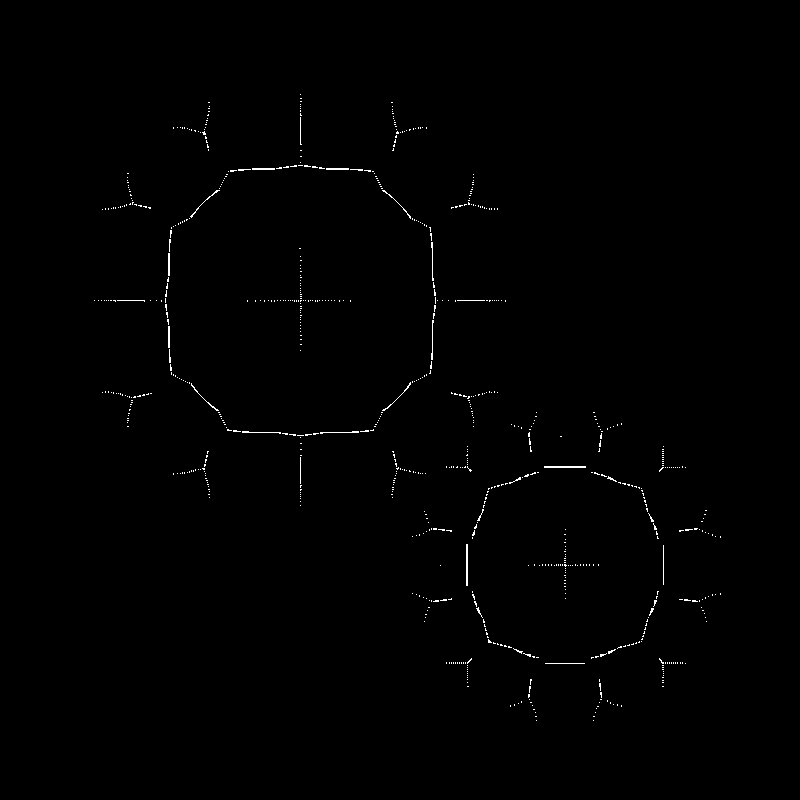

Skeleton 3


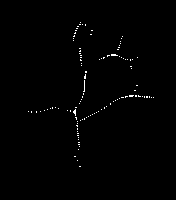

In [61]:
skeletons = []

for img in images:
    skeleton = skeletonize(img)
    skeletons.append(skeleton)

# Display skeletons
for i, skel in enumerate(skeletons):
    print(f'Skeleton {i+1}')
    cv2_imshow(skel)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [62]:
# Function to expand skeleton
def expand_skeleton(skeleton, iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    expanded = cv2.dilate(skeleton, kernel, iterations=iterations)
    return expanded

In [65]:
# Expand skeletons
restored_images = []

restored = expand_skeleton(skeletons[0], iterations=12)
restored_images.append(restored)

restored = expand_skeleton(skeletons[1], iterations=30)
restored_images.append(restored)

restored = expand_skeleton(skeletons[2], iterations=18)
restored_images.append(restored)

Original Image 1


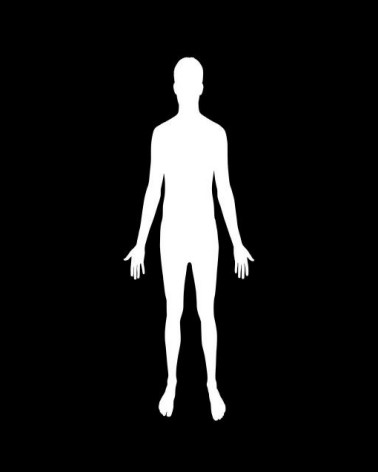

Expanded Image 1


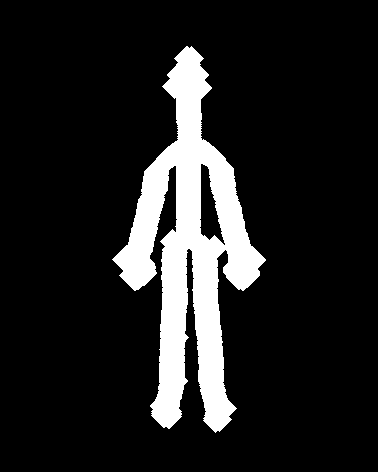

Original Image 2


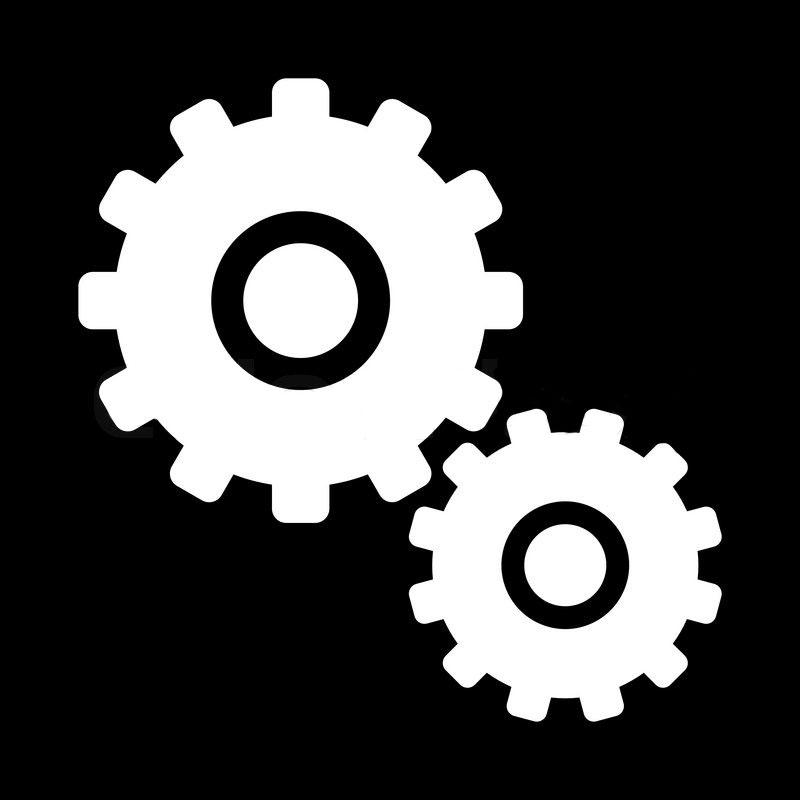

Expanded Image 2


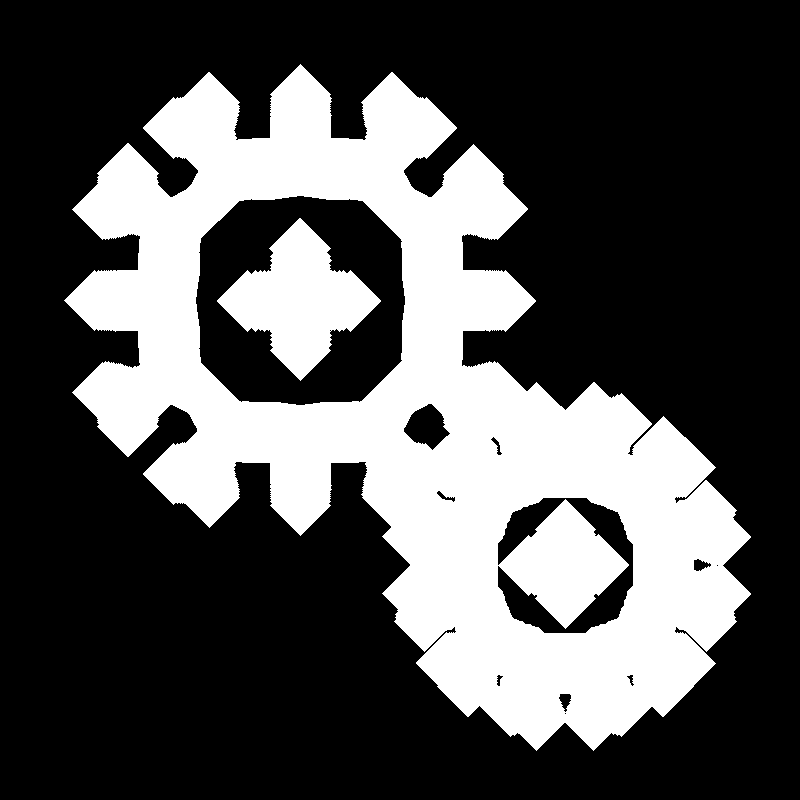

Original Image 3


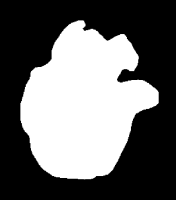

Expanded Image 3


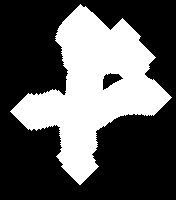

In [70]:
# Display original and expanded images
for i, (original, inpainted) in enumerate(zip(images, restored_images)):
    print(f'Original Image {i+1}')
    cv2_imshow(original)

    print(f'Expanded Image {i+1}')
    cv2_imshow(inpainted)
    cv2.waitKey(0)
    cv2.destroyAllWindows()